# **NutriSnap-HAI** 🥗




Ce notebook s’inscrit dans le cadre du projet **NutriSnap-HAI**, dont l’objectif est d’étudier les interactions Humain–IA dans un contexte d’***estimation nutritionnelle à partir d’images alimentaires***.

L’application envisagée repose sur un modèle d’analyse d’images capable d’estimer les macronutriments et micronutriments d’un plat, tout en associant chaque prédiction à un niveau d’incertitude explicite.

L’objectif de ce travail n’est pas d’évaluer la précision nutritionnelle du modèle, mais d’**analyser comment les utilisateurs interagissent avec une IA lorsqu’elle exprime différents niveaux de confiance**, et en particulier :
- dans quelles conditions l’utilisateur suit l’IA,
- quand il la rejette,
- et comment le contrôle humain est rétabli en cas d’incertitude.

À travers l’analyse de données d’interaction collectées lors d’un prototype expérimental, ce notebook vise à :
- mesurer la reliance utilisateur à l’IA,
- analyser les comportements de l'utilsateur face à l’incertitude,
- explorer les situations intermédiaires où l’automatisation n’est ni totalement suivie ni explicitement bloquée,
- et valider des garde-fous Humain–IA destinés à empêcher une automatisation inappropriée.

Les résultats présentés permettent de discuter la conception de systèmes IA responsables, capables de reconnaître leurs limites et de transférer explicitement la décision à l’utilisateur lorsque nécessaire.

### **1. Préparation et Nettoyage**




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv('logs.csv')
df.head()

,timestamp,session_id,trial_id,condition,ai_category,ai_text,ai_calories,ai_macros,ai_uncertainty,human_action,manual_input,final_entry,human_intervention,explanation_variant,correct,decision_time_ms,image_id
0,13/01/2026 21:07,00526388-169f-42f6-bf39-09927e02cff6,1,Humain (H_only),na,na,na,na,na,override,"Dessert fruits rouges, 500 Kcal, 10g/50g/15g","Dessert fruits rouges, 500 Kcal, 10g/50g/15g",1,na,na,88037,dessert_1.jpg
1,13/01/2026 21:10,00526388-169f-42f6-bf39-09927e02cff6,2,Humain (H_only),na,na,na,na,na,override,"Pizza au fromage, 700 Kcal, 30 g / 70 g / 30 g","Pizza au fromage, 700 Kcal, 30 g / 70 g / 30 g",1,na,na,63101,pizza_3.jpg
2,13/01/2026 21:13,00526388-169f-42f6-bf39-09927e02cff6,3,Humain (H_only),na,na,na,na,na,override,"Salade de carottes râpées, 160 kcal, 2 g / 20 ...","Salade de carottes râpées, 160 kcal, 2 g / 20 ...",1,na,na,58787,legume_3.jpg
3,13/01/2026 21:15,00526388-169f-42f6-bf39-09927e02cff6,4,Humain (H_only),na,na,na,na,na,override,"Filet de poisson sole, 320 kcal, 20 g / 10 g /...","Filet de poisson sole, 320 kcal, 20 g / 10 g /...",1,na,na,56374,poisson_3.jpg
4,13/01/2026 21:21,00526388-169f-42f6-bf39-09927e02cff6,5,Humain (H_only),na,na,na,na,na,override,"Pates au fromage / huile d'olive / parmesan, 6...","Pates au fromage / huile d'olive / parmesan, 6...",1,na,na,73628,pates_3.jpg


In [3]:
## Basic sanity checks ##

# Data Info
print("Dataframe Info:")
df.info()

# Missing values
print(df.isnull().sum())

# Description
print("\nData Description:")
df.describe()

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            79 non-null     object
 1   session_id           79 non-null     object
 2   trial_id             79 non-null     int64 
 3   condition            79 non-null     object
 4   ai_category          79 non-null     object
 5   ai_text              79 non-null     object
 6   ai_calories          79 non-null     object
 7   ai_macros            79 non-null     object
 8   ai_uncertainty       79 non-null     object
 9   human_action         79 non-null     object
 10  manual_input         79 non-null     object
 11  final_entry          79 non-null     object
 12  human_intervention   79 non-null     int64 
 13  explanation_variant  79 non-null     object
 14  correct              79 non-null     object
 15  decision_time_ms     79 non-null     int64 

,trial_id,human_intervention,decision_time_ms
count,79.000000,79.000000,79.000000
mean,5.265823,0.632911,35913.936709
std,2.898757,0.485091,26678.319052
min,1.000000,0.000000,3614.000000
25%,3.000000,0.000000,12386.000000
50%,5.000000,1.000000,30592.000000
75%,8.000000,1.000000,57212.500000
max,10.000000,1.000000,115352.000000


**Séparation des deux groupes Humain (H_only) et IA (H+IA)**

In [4]:
df_h_only = df[df["condition"] == "Humain (H_only)"].copy()
df_h_ai   = df[df["condition"] == "IA (H+IA)"].copy()


### **2. Calcul de la Reliance**
On calcule la Reliance uniquement sur le groupe IA (H+IA) :

*Reliance = P(suivre IA | IA correcte) – P(suivre IA | IA incorrecte)*

In [5]:
# P(suivre IA | IA correcte)
p_accept_given_correct = (
    df_h_ai[df_h_ai["correct"] == "Y"]["human_action"]
    .eq("accept")
    .mean()
)

# P(suivre IA | IA incorrecte)
p_accept_given_incorrect = (
    df_h_ai[df_h_ai["correct"] == "N"]["human_action"]
    .eq("accept")
    .mean()
)

# Reliance = P(suivre IA | IA correcte) – P(suivre IA | IA incorrecte)
reliance_score = p_accept_given_correct - p_accept_given_incorrect

print(f"P(suivre IA | IA correcte) :", round(p_accept_given_correct, 2))
print(f"P(suivre IA | IA incorrecte) : ", round(p_accept_given_incorrect, 2))
print(f"Reliance score : ", round(reliance_score, 2))


P(suivre IA | IA correcte) : 0.54
P(suivre IA | IA incorrecte) :  0.26
Reliance score :  0.28


**2.1 Analyse de la Reliance**

La Reliance a été calculée en comparant la probabilité que l’utilisateur accepte la proposition de l’IA lorsque celle-ci est correcte, et lorsqu’elle est incorrecte. **Dans nos données, l’utilisateur accepte l’estimation de l’IA dans 54 % des cas lorsque celle-ci est correcte, contre 26 % des cas lorsqu’elle est erronée, ce qui conduit à un score de Reliance de 0,28.**

Ce résultat montre que l’utilisateur ne suit pas systématiquement l’IA. Il a tendance à l’accepter plus souvent lorsqu’elle fournit une estimation correcte, et à se montrer plus critique lorsqu’elle se trompe. La Reliance observée est donc positive, mais modérée, ce qui suggère un comportement relativement équilibré plutôt qu’une confiance aveugle.

Dans le cadre exploratoire de ce prototype, ce score indique que l’IA est utilisée comme une **aide à la décision** plutôt que comme une autorité automatique. Les choix de conception du système, notamment l’affichage de l’incertitude, la possibilité d’ajuster la réponse et la présence d’explications, semblent encourager un usage réfléchi de l’IA, tout en laissant à l’utilisateur un réel contrôle sur la décision finale.

**2.2 Niveau de confiance dans l'acceptation**

In [6]:
# Calcul du taux d'acceptation selon que l'IA est correcte ou non
accept_rate = (
    df_h_ai
    .groupby("correct")["human_action"]
    .apply(lambda x: (x == "accept").mean())
    .mul(100)
    .round(1)
)

# Mise en forme du tableau
accept_table = accept_rate.reset_index()
accept_table.columns = [
    "IA correcte ?",
    "Taux d’acceptation (%)"
]

accept_table


,IA correcte ?,Taux d’acceptation (%)
0,N,26.1
1,Y,53.8


Le tableau des taux d’acceptation permet de préciser cette observation. Même lorsque l’IA est incorrecte, l’utilisateur accepte sa proposition dans environ **26 %** des cas, ce qui montre que la confiance accordée à l’IA n’est ni totale ni parfaitement discriminante. Ce résultat souligne l’intérêt des mécanismes de contrôle et de correction intégrés au prototype.

Si la Reliance permet d’analyser le rapport de confiance entre l’utilisateur et l’IA, elle ne permet pas à elle seule d’évaluer l’efficacité de l’interaction. Or, l’un des objectifs du prototype NutriSnap-HAI est de **faciliter l’identification rapide d’un repas**.

La section suivante analyse donc la performance de l’interaction, en comparant les **temps de décision** entre la condition H_only et la condition H+IA, afin d’évaluer si l’assistance de l’IA permet un réel gain de temps tout en maintenant le contrôle de l’utilisateur.

### **3. Analyse de la performance (Identification rapide du repas)**

**3.1 Comparaison globale des temps de décision**

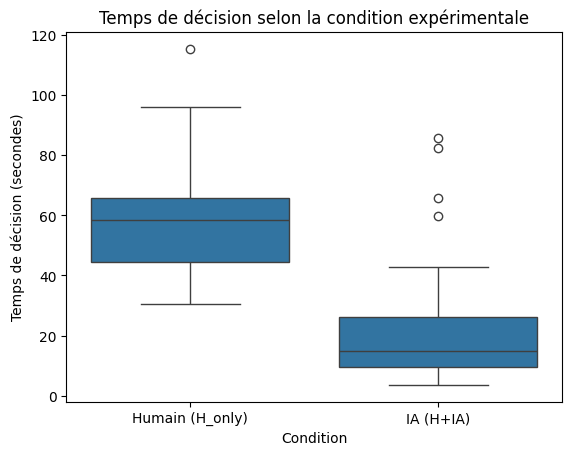

In [7]:
# Ajout d'une colonne secondes pour meilleure intuition
df["decision_time_s"] = df["decision_time_ms"] / 1000

# Boxplot
sns.boxplot(
    data=df,
    x="condition",
    y="decision_time_s"
)

plt.title("Temps de décision selon la condition expérimentale")
plt.ylabel("Temps de décision (secondes)")
plt.xlabel("Condition")
plt.show()


Ce graphique montre une différence très claire entre les deux conditions. Lorsque l’utilisateur agit **seul**, les temps de décision sont globalement **plus longs** et plus variables. Cela s’explique par le fait que l’identification du repas et la saisie des informations doivent être faites entièrement à la main.

À l’inverse, en condition **IA**, les temps de décision sont nettement **plus courts**. L’utilisateur peut s’appuyer sur la proposition de l’IA et se concentrer sur la validation ou l’ajustement de l’estimation, ce qui réduit fortement le temps nécessaire pour enregistrer le repas.

La présence de quelques valeurs plus élevées en condition IA suggère néanmoins que l’utilisateur prend parfois davantage de temps pour corriger ou vérifier l’estimation, ce qui reste cohérent avec un **usage réfléchi de l’IA**.

**3.2 Analyse miroir par image**

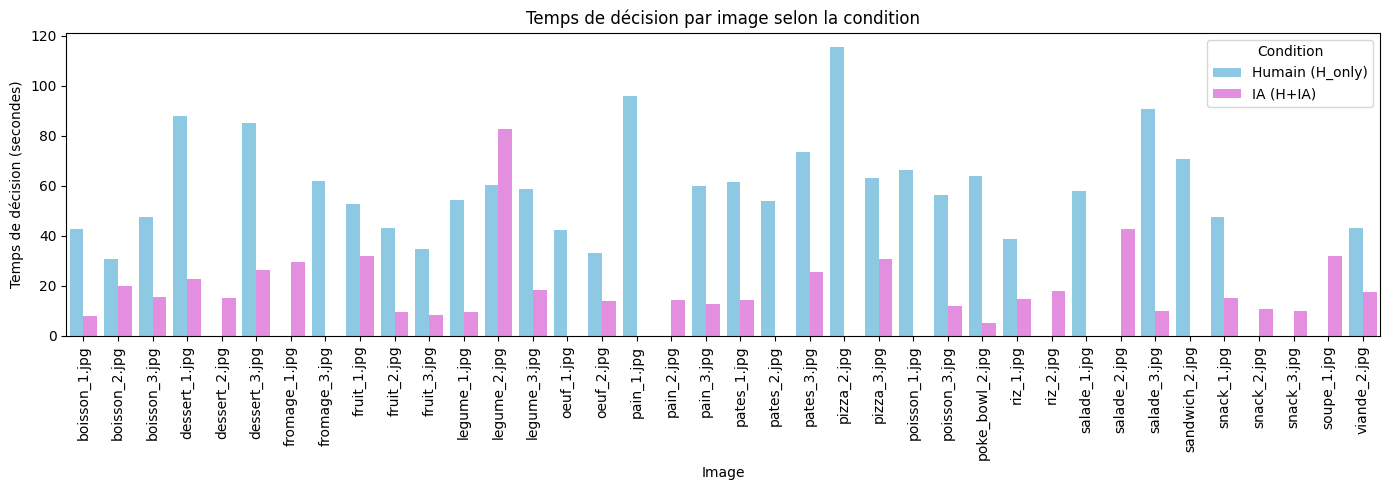

In [8]:
# Tps par image
time_by_image = (
    df.groupby(["image_id", "condition"])["decision_time_s"]
    .median()
    .reset_index()
)

# Visualisation
plt.figure(figsize=(14, 5))

sns.barplot(
    data=time_by_image,
    x="image_id",
    y="decision_time_s",
    hue="condition",
    palette={
        "Humain (H_only)": "#80CEF2",  # bleu clair
        "IA (H+IA)": "#F280ED"          # rose clair
    }
)

plt.title("Temps de décision par image selon la condition")
plt.ylabel("Temps de décision (secondes)")
plt.xlabel("Image")
plt.xticks(rotation=90)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()


**Analyse miroir par image**

Ce graphique présente, pour chaque image utilisée dans l’étude, les temps de décision observés en condition H_only et en condition H+IA. Cette visualisation permet de comparer directement l’effet de l’assistance de l’IA pour un même stimulus visuel.

On observe que, pour la majorité des images, **le temps de décision est systématiquement plus faible en condition H+IA.** Cette tendance se retrouve quel que soit le type de plat représenté, ce qui suggère que le gain de temps apporté par l’IA ne dépend pas uniquement de certaines images « faciles », mais constitue un effet global de l’assistance proposée.

Cette analyse confirme que l’IA facilite l’**identification rapide** du repas de manière cohérente d’une image à l’autre.

### **4. Analyse du comportement face à l'incertitude (G2 & G10)**

**4.1 Temps de décision selon l'incertitude**

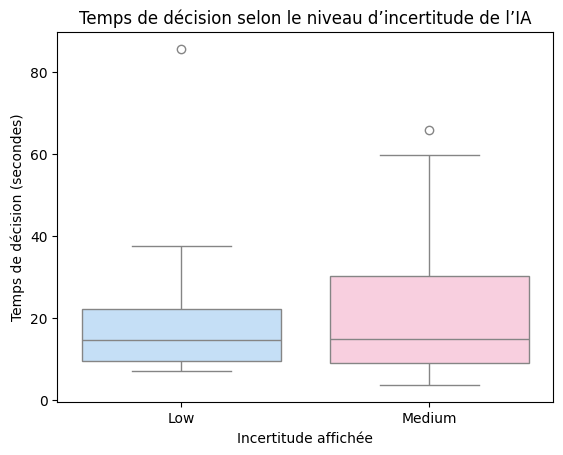

In [9]:
# Incertitude
df_h_ai_uncertainty = df[
    (df["condition"] == "IA (H+IA)") &
    (df["ai_uncertainty"].isin(["Low", "Medium"]))
].copy()

# Visualisation
sns.boxplot(
    data=df_h_ai_uncertainty,
    x="ai_uncertainty",
    y="decision_time_s",
    hue="ai_uncertainty",
    palette={"Low": "#bde0fe", "Medium": "#ffc8dd"}
)

plt.title("Temps de décision selon le niveau d’incertitude de l’IA")
plt.xlabel("Incertitude affichée")
plt.ylabel("Temps de décision (secondes)")
plt.show()

**Effet de l’incertitude sur le temps de décision**

Ce graphique montre que le niveau d’incertitude affiché par l’IA a un impact sur le temps de décision de l’utilisateur. Lorsque l’incertitude est **faible**, les temps de décision sont globalement **plus courts** et plus concentrés autour d’une valeur médiane relativement basse.

En revanche, lorsque l’incertitude est **moyenne**, on observe une **plus grande dispersion des temps de décision**, avec certaines décisions nettement **plus longues**. Cela suggère que l’utilisateur prend davantage de temps pour évaluer la proposition de l’IA lorsque celle-ci exprime une incertitude plus élevée.

Ce résultat va dans le sens d’un **usage réfléchi de l’IA**, où le signal d’incertitude semble encourager une prise de décision plus prudente plutôt qu’une acceptation automatique.

À noter que le niveau d’incertitude **High** n’est pas inclus dans cette analyse, car il correspond à un **cas d’abstention de l’IA**, pour lequel aucune estimation n’est fournie. Ce choix reflète un mécanisme de sécurité du système visant à éviter une décision automatisée lorsque la confiance de l’IA est jugée insuffisante.

**4.2 Taux d'override selon l'incertitude**

Taux d'override : ai_uncertainty
Low       29.03
Medium    56.25
Name: is_override, dtype: float64




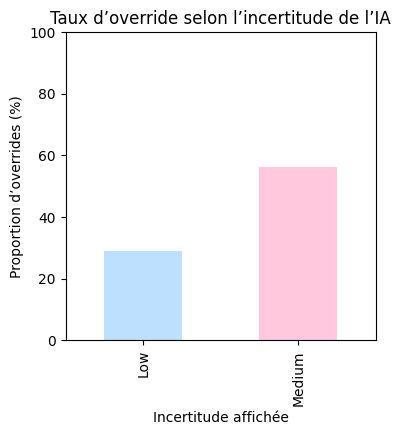

In [10]:
# Création d'une variable binaire “override”
df_h_ai_uncertainty["is_override"] = (
    df_h_ai_uncertainty["human_action"] == "override"
).astype(int)

# Calcul du taux d'override
override_rate = (
    df_h_ai_uncertainty
    .groupby("ai_uncertainty")["is_override"]
    .mean()
)

# Affichage en pourcentage
override_rate_pct = override_rate * 100
print("Taux d'override :", override_rate_pct.round(2))
print("\n")

# Visualisation
override_rate_pct.plot(
    kind="bar",
    color=["#bde0fe", "#ffc8dd"],
    figsize=(4, 4)
)

plt.title("Taux d’override selon l’incertitude de l’IA")
plt.ylabel("Proportion d’overrides (%)")
plt.xlabel("Incertitude affichée")
plt.ylim(0, 100)
plt.show()


**Taux d’override selon l’incertitude de l’IA**

Le graphique met en évidence une différence marquée dans le recours à l’action **ALMOST THERE** selon le niveau d’incertitude affiché par l’IA. Lorsque l’incertitude est **faible (low)**, l’utilisateur corrige la proposition de l’IA dans environ **29 %** des cas.

En revanche, lorsque l’incertitude est **moyenne (medium)**, ce taux d’override augmente nettement pour atteindre environ **56 %**. Cette évolution suggère que l’utilisateur tient compte du signal d’incertitude communiqué par l’IA et adopte une posture plus critique lorsque la fiabilité perçue de l’estimation diminue.

Le **bouton ALMOST THERE** apparaît ainsi comme un mécanisme central de régulation de l’interaction, permettant une correction graduelle plutôt qu’une acceptation ou un rejet systématique.

**4.3 Temps de décision selon l'action (accept/override/reject)**

In [11]:
# Conversion du temps de décision en secondes (plus lisible)
df_h_ai["decision_time_s"] = df_h_ai["decision_time_ms"] / 1000

time_by_action = (
    df_h_ai
    .groupby("human_action")["decision_time_s"]
    .mean()
    .round(2)
)

time_by_action


,decision_time_s
human_action,
accept,14.38
override,34.35
reject,7.57


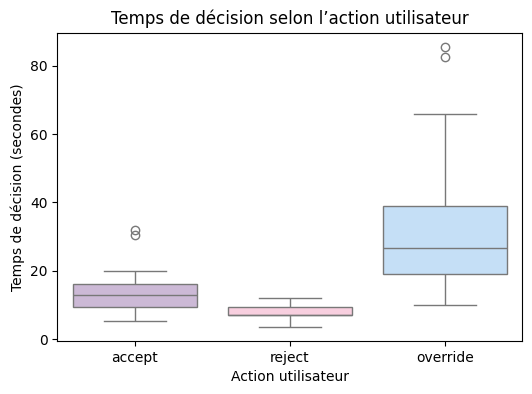

In [12]:
# Affichage
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_h_ai,
    x="human_action",
    y="decision_time_s",
    hue="human_action",
    palette=["#cdb4db", "#ffc8dd", "#bde0fe"]
)

plt.xlabel("Action utilisateur")
plt.ylabel("Temps de décision (secondes)")
plt.title("Temps de décision selon l’action utilisateur")
plt.show()


**Temps de décision selon l'action**

Le temps de décision varie fortement selon l’action effectuée par l’utilisateur. Les rejets sont associés aux temps les plus courts, suggérant une décision rapide lorsque la proposition de l’IA est jugée inacceptable. Les acceptations nécessitent un temps intermédiaire, tandis que les overrides présentent les temps de décision les plus élevés et la plus forte variabilité. Ce résultat confirme que l’override correspond à une situation de réflexion accrue, dans laquelle l’utilisateur évalue la proposition de l’IA avant d’y apporter des ajustements. L’**override** apparaît ainsi comme un **compromis entre confiance et contrôle**, impliquant un effort cognitif plus important que l’acceptation ou le rejet.

### **5. Analyse qualitative des « override » (ALMOST THERE)**

Cette section vise à mieux comprendre la nature des situations dans lesquelles l’utilisateur choisit de corriger l’IA. Plutôt que de considérer l’override comme un simple rejet, nous analysons les corrections effectuées, leur contexte, ainsi que les facteurs susceptibles d’influencer cette décision.

In [13]:
# Cas ALMOST THERE
df_overrides = df[
    (df["condition"] == "IA (H+IA)") &
    (df["human_action"] == "override")
].copy()

print("Nombre de cas d'override :", len(df_overrides))


Nombre de cas d'override : 20


In [14]:
df_overrides.head(5)


,timestamp,session_id,trial_id,condition,ai_category,ai_text,ai_calories,ai_macros,ai_uncertainty,human_action,manual_input,final_entry,human_intervention,explanation_variant,correct,decision_time_ms,image_id,decision_time_s
42,14/01/2026 16:04,88a27284-740c-4b03-836d-7b195c4fcf8d,1,IA (H+IA),Salade,Salade,80,30 g / 70 g / 30 g,Low,override,"Pizza fromage/tomates/poivrons, 700 kcal, 30 g...","Pizza fromage/tomates/poivrons, 700 kcal, H44",1,"Tomates, concombres, avocat",N,85572,pizza_3.jpg,85.572
45,14/01/2026 16:09,88a27284-740c-4b03-836d-7b195c4fcf8d,2,IA (H+IA),Salade,Salade composée,250,5 g / 30 g / 15 g,Medium,override,"Snack kinder bueno, 250 kcal, 5 g / 30 g / 15 g","Snack kinder bueno, 250 kcal, 5 g / 30 g / 15 g",1,"Maïs, tomates, avocat, olives",N,59686,snack_2.jpg,59.686
48,14/01/2026 16:13,88a27284-740c-4b03-836d-7b195c4fcf8d,3,IA (H+IA),Fruit,Orange,65,1 g / 35 g / 0 g,Low,override,"Mangue, 135 kcal, 1 g / 35 g / 0 g","Mangue, 135 kcal, 1 g / 35 g / 0 g",1,"Orange fraîche,\nPortion : 1 fruit moyen,\nFru...",N,37104,fruit_2.jpg,37.104
49,14/01/2026 16:17,88a27284-740c-4b03-836d-7b195c4fcf8d,4,IA (H+IA),Soupe,Soupe aux légumes,280,14 g / 36 g / 6 g,Medium,override,"Soupe aux légumes et lentilles, 280 kcal, 14 g...","Soupe aux légumes et lentilles, 280 kcal, 14 g...",1,"Légumes variés (courge, carotte, tomate, oigno...",Y,31899,soupe_1.jpg,31.899
50,14/01/2026 16:21,88a27284-740c-4b03-836d-7b195c4fcf8d,5,IA (H+IA),Pates,Pates au fromage et à l'huile d'olive,620,18 g / 65 g / 30 g,Low,override,"Pates au fromage et à l'huile d'olive, 620 kca...","Pates au fromage et à l'huile d'olive, 620 kca...",1,"Pâtes (portion généreuse),\nFromage râpé,\nHui...",Y,37522,pates_3.jpg,37.522


**5.1 Analyse que *quoi* est corrigé**

Séparation [ identification ], [ calories ], [ P/G/L ]

In [15]:
def split_entry_safe(text):
    parts = [p.strip().lower().replace(" ", "").replace("g", "").replace("kcal", "") for p in str(text).split(",")]
    while len(parts) < 3:
        parts.append("na")
    return parts[:3]  # [label, calories, macros]


In [16]:
# AI
df_overrides[["ai_label", "ai_cal", "ai_macros"]] = (
    df_overrides
    .apply(
        lambda row: split_entry_safe(
            f"{row['ai_text']}, {row['ai_calories']} kcal, {row['ai_macros']}"
        ),
        axis=1
    )
    .apply(pd.Series)
)

# Humain
df_overrides[["human_label", "human_cal", "human_macros"]] = (
    df_overrides["final_entry"]
    .apply(split_entry_safe)
    .apply(pd.Series)
)




In [17]:
# [Identification]
df_overrides["label_corrected"] = (
    df_overrides["ai_label"] != df_overrides["human_label"]
)

# [Calories]
df_overrides["calories_corrected"] = (
    df_overrides["ai_cal"] != df_overrides["human_cal"]
)

# [Macros]
df_overrides["macros_corrected"] = (
    df_overrides["ai_macros"] != df_overrides["human_macros"]
)



In [18]:
# Resultat
summary = (
          df_overrides[
                  ["label_corrected", "calories_corrected", "macros_corrected"]
                      ].mean() * 100
)

summary.name = "Taux de correction (%)"
summary.index = [
    "Identification du plat",
    "Calories",
    "Macros (P/G/L)"
]

summary

,Taux de correction (%)
Identification du plat,70.0
Calories,25.0
Macros (P/G/L),15.0


L’analyse des actions d’override met en évidence des différences nettes selon le type d’information corrigée. Dans **70 %** des cas, l’utilisateur modifie l’**identification du plat**, ce qui suggère que l’override est principalement utilisé pour corriger une reconnaissance jugée inexacte ou imprécise.

En revanche, les corrections portant sur les **calories (25 %)** et surtout sur les **macros (15 %)** sont nettement moins fréquentes.

Cela indique que, même lorsqu’ils reprennent le contrôle de l’interface, les utilisateurs tendent à accepter les estimations nutritionnelles proposées par l’IA, probablement en raison d’une difficulté perçue à estimer précisément les quantités.

**5.2 Détection des corrections effectives lors d’un override**

Un override est considéré comme une correction effective si au moins une des composantes (plat, calories, macros) diffère entre la proposition de l’IA et l’entrée finale de l’utilisateur.

In [19]:
df_overrides["any_effective_correction"] = (
    (df_overrides["ai_label"]   != df_overrides["human_label"]) |
    (df_overrides["ai_cal"]     != df_overrides["human_cal"]) |
    (df_overrides["ai_macros"]  != df_overrides["human_macros"])
)

# Identification des overrides sans correction réelle
df_overrides["override_no_correction"] = ~df_overrides["any_effective_correction"]


In [20]:
# Proportion d’overrides avec et sans correction effective
override_df = (df_overrides["override_no_correction"].value_counts(normalize=True) * 100)
override_df.index = [
    "Override avec correction effective",
    "Override sans correction effective"
]
override_df.name = "Taux (%)"

override_df

,Taux (%)
Override avec correction effective,75.0
Override sans correction effective,25.0


L’analyse montre que tous les overrides ne correspondent pas à une correction effective. Environ **25 %** des overrides sont déclenchés alors que l’identification du plat, les calories et les macros enregistrées sont strictement identiques à la proposition initiale de l’IA.

Ce résultat suggère que l’override peut également être utilisé comme un **mécanisme de vérification ou de réassurance**, **permettant à l’utilisateur de reprendre temporairement le contrôle de l’interface** sans pour autant remettre en cause l’estimation fournie. Ce comportement illustre une forme de confiance pragmatique envers l’IA, caractéristique d’une interaction humain–IA nuancée et non binaire.

**5.3 Influence de l'essai précédent**

*Le taux d’override augmente-t-il quand les erreurs s’accumulent ?*

In [21]:
# Taille de la fenêtre d'observation
window = 5

# Nombre d'erreurs de l'IA sur les 'window' essais précédents
df_h_ai["prev_errors"] = (
    df_h_ai["correct"]
    .eq("N")                               # True si erreur IA
    .groupby(df_h_ai["session_id"])        # par session utilisateur
    .rolling(window)                       # fenêtre glissante
    .sum()                                 # nombre d'erreurs
    .shift(1)                              # on exclut l'essai courant
    .reset_index(level=0, drop=True)
)

# Nettoyage
df_seq = df_h_ai.dropna(subset=["prev_errors"]).copy()
df_seq["prev_errors"] = df_seq["prev_errors"].astype(int)


# Calcul du taux d'override
override_rate_seq = (
    df_seq
    .groupby("prev_errors")["human_action"]
    .apply(lambda x: (x == "override").mean())
    .mul(100)
    .round(1)
)

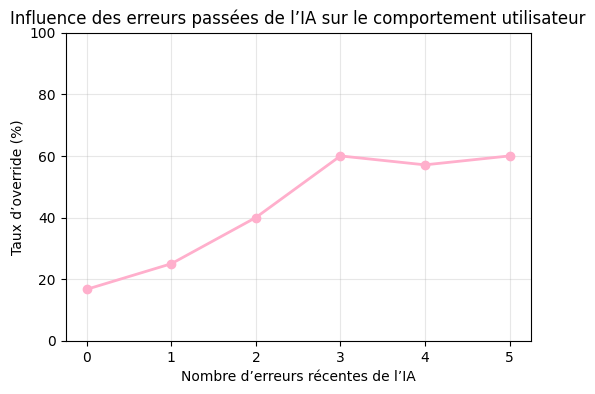

In [22]:
# Affichage
plot_df = override_rate_seq.reset_index()
plot_df.columns = ["Nombre d’erreurs récentes", "Taux d’override (%)"]

plt.figure(figsize=(6, 4))
plt.plot(
    plot_df["Nombre d’erreurs récentes"],
    plot_df["Taux d’override (%)"],
    marker="o",
    linewidth=2,
    color="#ffafcc"
)

plt.xlabel("Nombre d’erreurs récentes de l’IA")
plt.ylabel("Taux d’override (%)")
plt.title("Influence des erreurs passées de l’IA sur le comportement utilisateur")
plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.show()

Cette analyse met en évidence un **effet cumulatif des erreurs passées de l’IA sur le comportement utilisateur**. Le taux d’override augmente progressivement avec le nombre d’erreurs récentes, passant d’environ **17 %** lorsque l’IA a été fiable à près de **60 %** après plusieurs erreurs successives. Ce résultat suggère que les utilisateurs intègrent l’historique de performance de l’IA dans leur prise de décision, et non uniquement la qualité de la prédiction courante.

**5.4 Rôle de l'explicabilité**

In [23]:
# Longueur de l'explication (en nombre de mots)
df["explanation_length"] = (
    df["explanation_variant"]
    .astype(str)
    .str.split()
    .apply(len)
)

# On analyse dans le cas de "IA (H+IA)"
df_exp = df[df["condition"] == "IA (H+IA)"].copy()


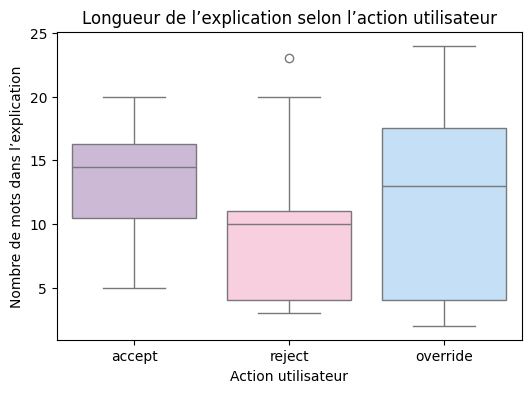

In [24]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_exp,
    x="human_action",
    y="explanation_length",
    hue="human_action",
    palette=["#cdb4db", "#ffc8dd", "#bde0fe"]
)

plt.title("Longueur de l’explication selon l’action utilisateur")
plt.xlabel("Action utilisateur")
plt.ylabel("Nombre de mots dans l’explication")
plt.show()


**- Acceptation**

Les actions d’acceptation sont associées aux explications les plus longues en médiane (environ 14 à 15 mots), avec une dispersion relativement limitée.
Cela suggère que, lorsque l’utilisateur accepte la proposition de l’IA, l’explication fournie est perçue comme claire et suffisamment détaillée pour justifier l’estimation. L’explicabilité joue ici un rôle de renforcement de la **confiance**, en donnant à l’utilisateur le sentiment que la décision de l’IA repose sur des éléments compréhensibles et cohérents.

**- Rejet**

Les rejets correspondent aux explications les plus courtes, avec une médiane autour de 10 mots et une forte concentration de valeurs faibles.
Dans ces situations, l’explication apparaît souvent **trop pauvre ou trop vague** pour permettre à l’utilisateur de comprendre le raisonnement de l’IA. Le rejet peut alors être interprété comme une rupture du contrat d’interaction, où l’utilisateur ne parvient ni à valider la prédiction, ni à s’appuyer sur l’IA pour ajuster sa décision.

**- Override (ALMOST THERE)**

Les overrides présentent une médiane intermédiaire (environ 12 à 13 mots), mais surtout une dispersion beaucoup plus élevée que les autres actions.
On observe à la fois des overrides associés à des explications très courtes et d’autres associés à des explications relativement longues. Cette variabilité suggère que l’override correspond à une **zone grise de confiance** : l’utilisateur comprend partiellement la proposition de l’IA, mais estime néanmoins nécessaire de reprendre la main pour ajuster le résultat.

Contrairement au rejet, l’override ne traduit pas un désaccord total, mais plutôt une **adhésion partielle**, où **l’IA est perçue comme utile sans être pleinement fiable**.

**-> Interprétation globale**

Ces résultats montrent que **l’explicabilité influence le comportement utilisateur**, mais de manière non binaire.
Une explication trop courte tend à conduire au rejet, tandis qu’une explication suffisamment détaillée favorise l’acceptation. Les situations intermédiaires donnent lieu à des overrides, indiquant que l’utilisateur ne se situe ni dans une confiance aveugle, ni dans un rejet systématique.

Ainsi, **l’action override apparaît comme un mécanisme clé d’interaction humain–IA**, permettant à l’utilisateur de conserver le contrôle tout en tirant parti de l’assistance proposée par le système.

### **6. Validation des gardes-fous**

**6.1 GF1 - Passage forcée en saisie manuelle**

Résultat attendu : 100 % des cas avec human_intervention = 1

*Ce résultat confirme le bon fonctionnement du garde-fou GF1, empêchant toute poursuite de l'interaction sans reprise explicite du contrôle par l'utilisateur.*

In [25]:
# Action de l’essai précédent (par session)
df_h_ai["prev_action"] = (
    df_h_ai
    .groupby("session_id")["human_action"]
    .shift(1)
)

# Deux rejets consécutifs -> déclenchement du GF1
df_h_ai["gf1_trigger"] = (
    (df_h_ai["human_action"] == "reject") &
    (df_h_ai["prev_action"] == "reject")
)

# Action réalisée à l’essai suivant
df_h_ai["next_action"] = (
    df_h_ai
    .groupby("session_id")["human_action"]
    .shift(-1)
)

# Indicateur d’intervention humaine à l’essai suivant
df_h_ai["next_human_intervention"] = (
    df_h_ai
    .groupby("session_id")["human_intervention"]
    .shift(-1)
)

# Cas où le garde-fou GF1 a été déclenché
gf1_cases = df_h_ai[df_h_ai["gf1_trigger"]].copy()

# Vérification :
# Après GF1, l'utilisateur doit intervenir manuellement
gf1_validation = (
    gf1_cases["next_human_intervention"]
    .value_counts(normalize=True)
    * 100
)

gf1_validation


,proportion
next_human_intervention,
1.0,100.0


Après **deux rejets consécutifs** de la proposition de l’IA, le garde-fou GF1 force systématiquement un **passage en saisie manuelle**. L’analyse des logs montre que, **dans 100 % des cas**, l’action suivant le déclenchement du garde-fou correspond à une intervention humaine effective (human_intervention = 1). Ce résultat confirme que le système empêche toute poursuite de l’interaction sans reprise de contrôle par l’utilisateur lorsque la fiabilité perçue de l’IA devient insuffisante.

**6.2 GF2 - Abstension en cas d'incertitude élevée (G10)**

***6.2.1 Vérification de l'existence du cas "High incertitude"***


In [26]:
# Nombre total d'essais en condition IA
n_total = df_h_ai.shape[0]

# Cas où l'IA affiche une incertitude élevée
df_high_uncertainty = df_h_ai[df_h_ai["ai_uncertainty"] == "High"].copy()

# Nombre d'essais avec incertitude élevée
n_high = df_high_uncertainty.shape[0]

# Proportion
prop_high = round((n_high / n_total) * 100, 1)

print(f"Nombre total d’essais en condition IA : {n_total}")
print(f"Nombre d’essais avec incertitude élevée (High) : {n_high}")
print(f"Soit {prop_high} % des essais IA")


Nombre total d’essais en condition IA : 49
Nombre d’essais avec incertitude élevée (High) : 2
Soit 4.1 % des essais IA


***6.2.2 Incertitude élevée -> Contrôle humain obligatoire***

In [27]:
# Distribution des actions utilisateur lorsque l'incertitude est élevée
action_dist = (
    df_high_uncertainty["human_action"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

# Création du tableau final unifié
summary_df = action_dist.reset_index()
summary_df.columns = ["User action", "Percentage (%)"]

# Ajout de l'information sur l'intervention humaine
summary_df["Human intervention"] = (
    df_high_uncertainty["human_intervention"].mode()[0]
)

summary_df


,User action,Percentage (%),Human intervention
0,override,100.0,1


Bien que les situations d’incertitude élevée soient peu fréquentes (4.1 %), elles déclenchent systématiquement un mécanisme de sécurité empêchant toute décision automatique.

Le garde-fou 2 est pleinement respecté :
lorsqu’une **incertitude élevée est détectée**, l’automatisation est bloquée sans exception, et **le contrôle humain est obligatoirement rétabli.**

### **Conclusion**

Ce notebook a exploré les **interactions Humain–IA** au sein d’un prototype d’estimation nutritionnelle assistée par IA, en se concentrant sur la manière dont les utilisateurs réagissent aux prédictions du système et à l’incertitude qui leur est associée.

Les analyses montrent que **la reliance à l’IA n’est ni systématique ni passive**. Les utilisateurs ajustent leurs décisions en fonction de la cohérence des résultats, de l’historique des interactions et du niveau d’incertitude affiché par le système. L’acceptation, le rejet et la reprise de contrôle s’inscrivent ainsi dans une dynamique adaptative, révélatrice d’une interaction nuancée plutôt que binaire.

L’**incertitude de l’IA** joue un rôle central dans cette **régulation** : lorsqu’elle augmente, les temps de décision s’allongent et les comportements deviennent plus prudents. Ce signal explicite empêche une automatisation réflexe et encourage un **engagement cognitif** plus important de la part de l’utilisateur.

Les situations intermédiaires analysées montrent également que la confiance accordée à l’IA dépend de l’**expérience cumulée** de l’utilisateur, et non uniquement de la prédiction courante. Cette **mémoire interactionnelle** influence la prise de décision et renforce l’idée que la relation Humain–IA s’inscrit dans le temps.

Enfin, la validation des **garde-fous** confirme que le système respecte des principes stricts de contrôle humain : aucune acceptation n’est observée lorsque l’IA exprime une incertitude élevée, et toute situation critique déclenche systématiquement une reprise explicite de la décision par l’utilisateur.

Dans l’ensemble, ces résultats soulignent l’importance d’une **conception Humain–IA** dans laquelle l’incertitude n’est pas dissimulée, mais utilisée comme un mécanisme actif de **sécurité** et de **régulation de l’autonomie du système**. Bien que le prototype étudié repose sur un périmètre volontairement restreint, il met en lumière des principes de conception pertinents pour des systèmes IA plus complexes, en particulier dans des contextes sensibles où **le contrôle et la responsabilité doivent rester entre les mains de l’utilisateur.**